# Pymaceuticals Clinical Data Analysis
## 1. Import and Setup

In [113]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [114]:
# We are interested only in these four drugs
drugs_to_keep = ['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']

In [115]:
# Set the shared font configurations for title and axis labels
title_font = {'fontname':'Arial', 'size':20, 'color':'black', 'weight':'semibold' }              
axis_font = {'fontname':'Arial', 'size':16}
legend_font = {'size' : 15 }
ticks_fontsize = 14
marker_size = 14
fig_size = (16, 10)

# Set specific styles for every drug used (so the same drug will be painted in the same style on every chart)
# I avoid using red and green colors here as people tend to interpret 'green' as good and 'red' as bad
# Also I use 'markevery' property to hide markers on the 'zero' point because these markers are either
# cropped due to zero working as a left x-limit or the left x-limit is shifted which shows extra grid line
# and looks not very nice.
# Also due to the nature of the data (i.e. same starting conditions), all zero-point markers overlap each other
shared_style = { 'markersize': 6, 'markevery': (1, 1) }
styles = {
    drugs_to_keep[0]: { 'marker': '^', 'linestyle': '-', 'color': 'cornflowerblue', **shared_style},
    drugs_to_keep[1]: { 'marker': 'o', 'linestyle': '--', 'color': 'coral', **shared_style},
    drugs_to_keep[2]: { 'marker': 'x', 'linestyle': '-.', 'color': 'blueviolet', **shared_style},
    drugs_to_keep[3]: { 'marker': 'D', 'linestyle': '-', 'color': 'olive', **shared_style},
}

## 2. Load and Clean Data

In [116]:
# Load two dataframes (clinical trials and mice data)
mice_data_path = "../Input/mouse_drug_data.csv"
cancer_data_path = "../Input/clinicaltrial_data.csv"

mice_data = pd.read_csv(mice_data_path)
cancer_data = pd.read_csv(cancer_data_path)
# ... merge it together
data = mice_data.merge(cancer_data, on='Mouse ID')
# ... and keep only data on four specific drugs
data = data.loc[data['Drug'].isin(drugs_to_keep)].reset_index(drop=True)
data.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,q119,Ketapril,0,45.000000,0
1,q119,Ketapril,5,47.864440,0
2,q119,Ketapril,10,51.236606,0
3,n923,Ketapril,0,45.000000,0
4,n923,Ketapril,5,45.824881,0


In [117]:
# First lets check if we have empty values anywhere (we drop lines with no data at all)
data = data.dropna(how='all')
has_empty_values = pd.isnull(data).any().any()
print('There are empty values in dataframe' if has_empty_values else 'No empty values in dataframe')

No empty values in dataframe


## 3.  Tumor Response to Treatment

In [118]:
# Calculate mean tumor volume and standard error of mean for each drug and timepoint
data_by_drug_timepoint = data.groupby(['Drug', 'Timepoint'])
tumor_grouped_data = data_by_drug_timepoint['Tumor Volume (mm3)']
mean_tumor_volume = tumor_grouped_data.mean()
sem_tumor_volume = tumor_grouped_data.sem()

# Now lets convert these series into the dataframe where every drug data is in its separate column
mean_tumor_volume = mean_tumor_volume.unstack(level=0)
sem_tumor_volume = sem_tumor_volume.unstack(level=0)

# Lets merge those two frames just to see the whole picture
column_names = [(drug + ' (Mean)', drug + ' (SEM)') for drug in drugs_to_keep]
ordered_column_names = [column_name for column_name_pair in column_names for column_name in column_name_pair]
mean_and_sem_tumor_volume = pd.concat([
    mean_tumor_volume.rename(columns={column:column + ' (Mean)' for column in mean_tumor_volume.columns}), 
    sem_tumor_volume.rename(columns={column:column + ' (SEM)' for column in sem_tumor_volume.columns})
], axis=1).loc[:, ordered_column_names]
mean_and_sem_tumor_volume.head()

Drug,Capomulin (Mean),Capomulin (SEM),Infubinol (Mean),Infubinol (SEM),Ketapril (Mean),Ketapril (SEM),Placebo (Mean),Placebo (SEM)
Timepoint,,,,,,,,
0,45.000000,0.000000,45.000000,0.000000,45.000000,0.000000,45.000000,0.000000
5,44.266086,0.448593,47.062001,0.235102,47.389175,0.264819,47.125589,0.218091
10,43.084291,0.702684,49.403909,0.282346,49.582269,0.357421,49.423329,0.402064
15,42.064317,0.838617,51.296397,0.357705,52.399974,0.580268,51.359742,0.614461
20,40.716325,0.909731,53.197691,0.476210,54.920935,0.726484,54.364417,0.839609


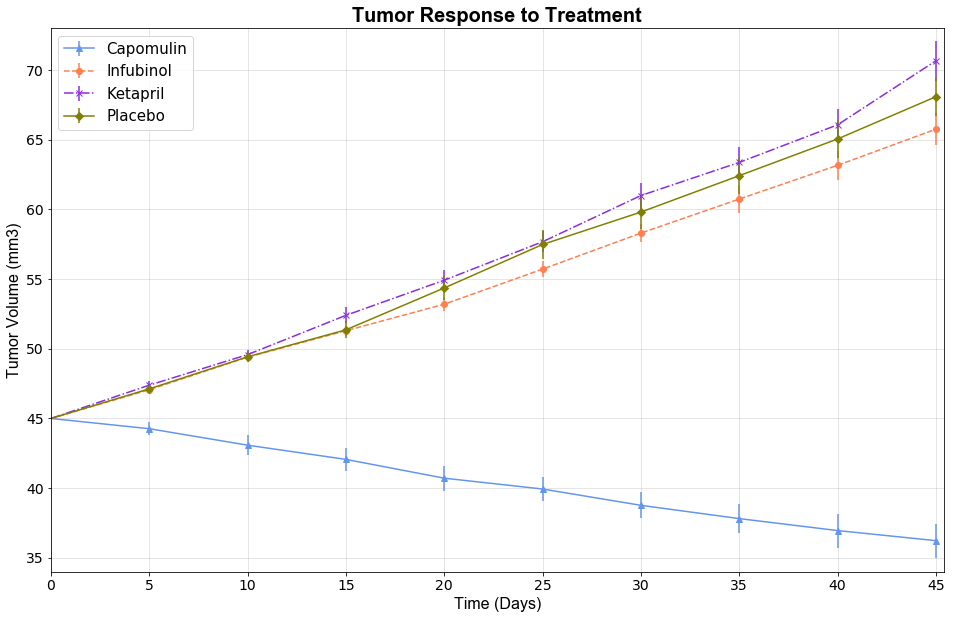

In [119]:
# Plotting all drug data on the same plot
plt.figure(figsize=fig_size)
# Though it is tempting to plot all the lines with a single command from pandas there is one bug (feature?)
# that doesn't allow both markers and errorbars to be printed
# see https://stackoverflow.com/questions/52035184/pandas-plot-line-graph-with-both-error-bars-and-markers
# for more details
for drug in drugs_to_keep:
    plt.errorbar(mean_tumor_volume.index.values,
                        mean_tumor_volume[drug], 
                        yerr=sem_tumor_volume[drug],
                        **styles[drug])
plt.xlabel('Time (Days)', **axis_font)
plt.xlim(0, mean_tumor_volume.index.values[-1] + 0.4)
plt.ylim(34, 73)
plt.xticks(mean_tumor_volume.index.values, fontsize=ticks_fontsize)
plt.ylabel('Tumor Volume (mm3)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title('Tumor Response to Treatment', **title_font)
plt.legend(loc='upper left', prop=legend_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Tumor Response to Treatment.png')
plt.show()

## 4. Metastatic Response to Treatment

In [120]:
# Calculate mean metastatic count and standard error of mean for each drug and timepoint
meta_sites_grouped_data = data_by_drug_timepoint['Metastatic Sites']
mean_meta_sites = meta_sites_grouped_data.mean()
sem_meta_sites = meta_sites_grouped_data.sem()

# Now lets convert these series into the dataframe where every drug data is in its separate column
mean_meta_sites = mean_meta_sites.unstack(level=0)
sem_meta_sites = sem_meta_sites.unstack(level=0)

# Lets merge those two frames just to see the whole picture
mean_and_sem_meta_sites = pd.concat([
    mean_meta_sites.rename(columns={column:column + ' (Mean)' for column in mean_tumor_volume.columns}), 
    sem_meta_sites.rename(columns={column:column + ' (SEM)' for column in sem_tumor_volume.columns})
], axis=1).loc[:, ordered_column_names]
mean_and_sem_meta_sites.head()

Drug,Capomulin (Mean),Capomulin (SEM),Infubinol (Mean),Infubinol (SEM),Ketapril (Mean),Ketapril (SEM),Placebo (Mean),Placebo (SEM)
Timepoint,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.074833,0.280000,0.091652,0.304348,0.098100,0.375000,0.100947
10,0.320000,0.125433,0.666667,0.159364,0.590909,0.142018,0.833333,0.115261
15,0.375000,0.132048,0.904762,0.194015,0.842105,0.191381,1.250000,0.190221
20,0.652174,0.161621,1.050000,0.234801,1.210526,0.236680,1.526316,0.234064


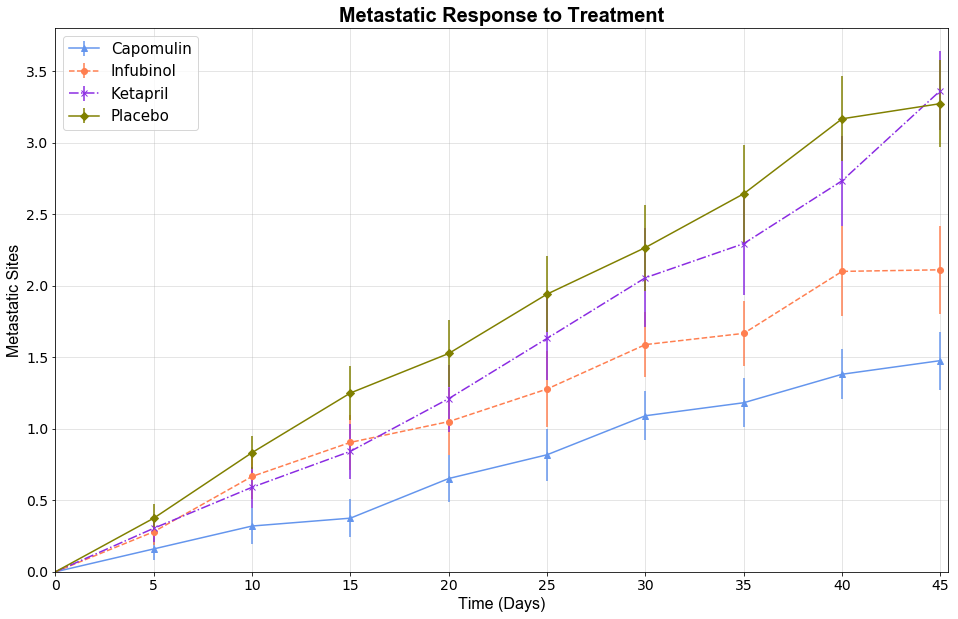

In [121]:
# Plotting all drug data on the same plot
plt.figure(figsize=fig_size)
for drug in drugs_to_keep:
    plt.errorbar(mean_meta_sites.index.values,
                        mean_meta_sites[drug], 
                        yerr=sem_meta_sites[drug],
                        **styles[drug])
plt.xlabel('Time (Days)', **axis_font)
plt.xlim(0, mean_meta_sites.index.values[-1] + 0.4)
plt.ylim(0, 3.8)
plt.xticks(mean_meta_sites.index.values, fontsize=ticks_fontsize)
plt.ylabel('Metastatic Sites', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title('Metastatic Response to Treatment', **title_font)
plt.legend(loc='upper left', prop=legend_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Metastatic Response to Treatment.png')
plt.show()

## 5. Survival Rates

In [122]:
# First lets calculate the survival rate. The values mean the percentage of the original mice population that
# is still alive at specific time point
survival_data = data_by_drug_timepoint['Mouse ID'].count()
survival_data = survival_data / survival_data.max() * 100
survival_data = survival_data.unstack(level=0)
survival_data.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,100.0,100.0,100.0,100.0
5,100.0,100.0,92.0,96.0
10,100.0,84.0,88.0,96.0
15,96.0,84.0,76.0,80.0
20,92.0,80.0,76.0,76.0


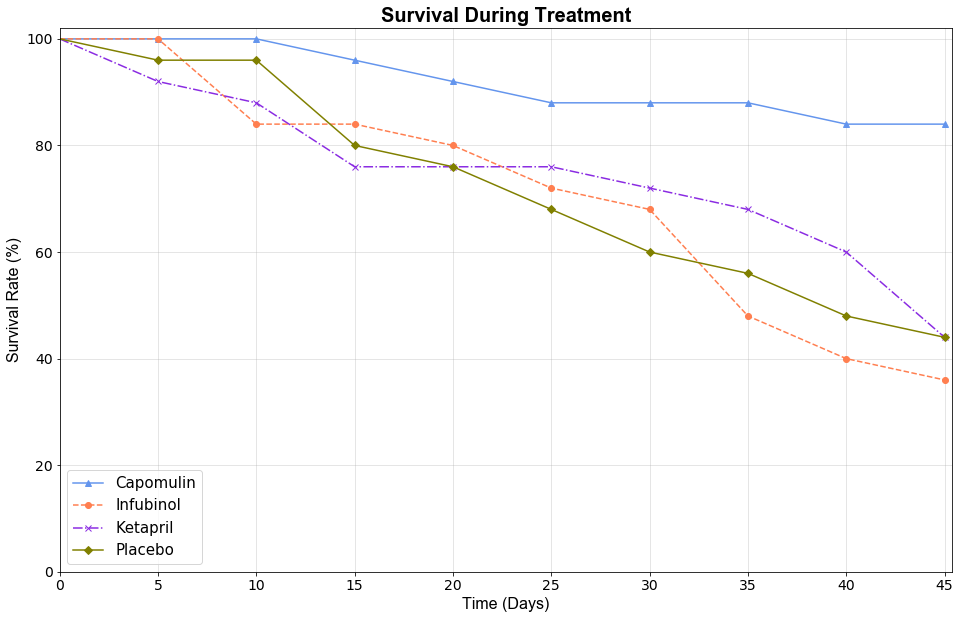

In [123]:
# Plotting all drug data on the same plot
plt.figure(figsize=fig_size)
for drug in drugs_to_keep:
    plt.plot(survival_data.index.values,
             survival_data[drug],
             **styles[drug])
plt.xlabel('Time (Days)', **axis_font)
plt.xlim(0, survival_data.index.values[-1] + 0.4)
plt.ylim(0, 102)
plt.xticks(survival_data.index.values, fontsize=ticks_fontsize)
plt.ylabel('Survival Rate (%)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title('Survival During Treatment', **title_font)
plt.legend(loc='lower left', prop=legend_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Survival During Treatment.png')
plt.show()